In [1]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install keras

In [0]:
!pip install tensorflow==1.8.0
!pip install Keras==2.2.4

In [0]:
import os
import sys
import random
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import cv2
import tensorflow as tf

In [0]:
%tensorflow_version 1.x
print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.8.0


In [0]:
!pip install tensorflow==1.8.0
!pip install Keras==2.2.4


**UNet Framework**

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
  us = keras.layers.UpSampling2D((2, 2))(x)
  concat = keras.layers.Concatenate()([us, skip])
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  return c
  
def UNet():
  f = [32, 64, 128, 256, 512]
  inputs = keras.layers.Input((512, 512, 3))
  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])

  bn = bottleneck(p4, f[4])
  u1 = up_block(bn, c4, f[3])
  u2 = up_block(u1, c3, f[2])
  u3 = up_block(u2, c2, f[1])
  u4 = up_block(u3, c1, f[0])
  outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(u4)
  outputs = Reshape(
            (512*512, 2),
            input_shape=(512, 512, 2))(outputs)
  model = keras.models.Model(inputs, outputs)
  return model

**Generator**


In [0]:
from keras.preprocessing.image import img_to_array


def category_label(labels, dims, n_labels):
    x = np.zeros([dims[0], dims[1], n_labels])
    #print(labels)
    for i in range(dims[0]):
        for j in range(dims[1]):
          x[i, j, (int)(labels[i][j]/255)] = 1
    x = x.reshape(dims[0] * dims[1], n_labels)
    return x


def data_gen_small(img_dir, mask_dir, lists, batch_size, dims, n_labels):
    while True:
        ix = np.random.choice(np.arange(len(lists)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            # images
            img_path = img_dir + lists.iloc[i, 0] + '.tif'
#            print( img_path )
            original_img = cv2.imread(img_path)[:, :, ::-1]
            resized_img = cv2.resize(original_img, (dims[0], dims[1]))
            array_img = img_to_array(resized_img)
#            print(array_img.size)
            imgs.append(array_img)
            # masks
            original_mask = cv2.imread(mask_dir + lists.iloc[i, 0] + '.tif')
            resized_mask = cv2.resize(original_mask, (dims[0], dims[1]))
#            print(resized_mask.shape)
            array_mask = category_label(resized_mask[:, :, 0], dims, n_labels)
            labels.append(array_mask)
        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels

**Training**

In [0]:
import pandas as pd
from keras.layers import Reshape

#from  model import segnet
#from generator import data_gen_small


def main():
    # set the necessary list
    train_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/train_list.csv", header=None)
    val_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/val_list.csv", header=None)

    # set the necessary directories
    trainimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/images/"
    trainmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"
    valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/images/"
    valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"

    train_gen = data_gen_small(trainimg_dir, trainmsk_dir,
            train_list, 8,
            [512, 512], 2)
    val_gen = data_gen_small(valimg_dir, valmsk_dir,
            val_list, 8,
            [512, 512], 2)
    model = UNet()
    print(model.summary())
    model.compile(loss="binary_crossentropy",
            optimizer="adam", metrics=["accuracy"])
    model.fit_generator(train_gen, steps_per_epoch=8,
            epochs=250, validation_data=val_gen,
            validation_steps=8)
    model.save_weights("/content/drive/My Drive/sarseg/UNet_200_epochs"+str(00)+".hdf5")
    model.save("/content/drive/My Drive/sarseg/UNet_200_epochs"+str(00)+".h5")
    print("save weight done..")



if __name__ == "__main__":
    main()


In [0]:
import pandas as pd
from keras.layers import Reshape
model = UNet()
print(model.summary())


**Loading Model**

In [5]:
import keras
import pandas as pd

from keras.models import load_model

def load(model_name):
  model_test = load_model("/content/drive/My Drive/sarseg/SAR dataset"+model_name+".h5")
  model_test.load_weights("/content/drive/My Drive/sarseg/SAR dataset"+model_name+".hdf5")
  print('model loaded')
  return model_test

model = "SAR_40_epochs"
model_test = load(model)

model loaded


<class 'keras.engine.training.Model'>


**Resume Training**

In [0]:
def train_resume(model_name):    
    train_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/train_list.csv", header=None)
    val_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/val_list.csv", header=None)

    # set the necessary directories
    trainimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/images/"
    trainmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"
    valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/images/"
    valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"

    train_gen = data_gen_small(trainimg_dir, trainmsk_dir,
            train_list, 8,
            [512, 512], 2)
    val_gen = data_gen_small(valimg_dir, valmsk_dir,
            val_list, 8,
            [512, 512], 2)
    model_test.fit_generator(train_gen, steps_per_epoch=8,
            epochs=10, validation_data=val_gen,
            validation_steps=8)
    model_test.save_weights("/content/drive/My Drive/sarseg/"+model_name +".hdf5")
    model_test.save("/content/drive/My Drive/sarseg/"+model_name +".h5")
    print("save weight done..")

new_model = "UNet_240_epochs"
train_resume(new_model)

In [0]:
model_name = "UNet_216_epochs"
model_test.save_weights("/content/drive/My Drive/sarseg/"+model_name +".hdf5")
model_test.save("/content/drive/My Drive/sarseg/"+model_name +".h5")
print("save weight done..")

save weight done..


f**Predicting Output**

In [0]:
from google.colab.patches import cv2_imshow
def pred_output(img_name):
  valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/"
  valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"
  test = np.zeros([1, 512, 512, 3])
  test_image = cv2.imread(valimg_dir + img_name)
  #print(test_image.shape)
  #print(cv2.imshow(test_image))
  tested = cv2.resize(test_image, (512, 512))
  test[0] = img_to_array(tested)

  # mask = np.zeros([1, 512, 512, 3])
  # test_image = cv2.imread(valmsk_dir + img_name)
  # tested = cv2.resize(test_image, (512, 512))
  # array_mask = category_label(tested[:, :, 0], (512, 512, 3), 2)

  predicted_out = model_test.predict(test)

  # array_mask.shape
  # mask = np.zeros([512, 512])
  # for i in range(512):
  #   for j in range(512):
  #     mask[i][j] = array_mask[i*512+j][0];

  predicted = predicted_out[0]
  predicted.shape
  pred = np.zeros([512, 512])
  for i in range(512):
    for j in range(512):
      pred[i][j] = 1-predicted[i*512+j][0];
  return pred, test
  # return pred, mask, test


name = 'SAR1.jpg'
pred, test = pred_output(name)

**Check threshold**

In [14]:
a = pred
a = (a < 0.5).astype(np.float32)
print(np.count_nonzero(a))
# print(np.count_nonzero(mask))

185320


**Plot Results**

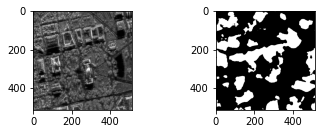

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(test[0].astype(int))
# ax2 = fig.add_subplot(2, 2, 2)
# ax2.imshow(mask, cmap= 'Greys')
ax3 = fig.add_subplot(2, 2, 2)
ax3.imshow(a, cmap= 'Greys')

Best till Now :- 160 epochs. loss = 0.06, 
216 epochs